In [18]:
import torch
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import timm

from PIL import Image
from torch import nn
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler


In [19]:
class LeafImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, train=True, transform=None, target_trainsform=None):
        self.img_labels = pd.read_csv(annotations_file)

        if train:
            unique_label = self.img_labels['label'].unique()
            self.label_mapping = {label: i for i, label in enumerate(unique_label)}
            for i in range(len(self.img_labels)):
                self.img_labels.loc[i, 'labeli']= self.label_mapping[self.img_labels.loc[i, 'label']] 
            self.img_labels.drop(['label'],axis=1,inplace=True)
        
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_trainsform
        self.train = train

    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path)
        if self.train:
            label = self.img_labels.iloc[idx, 1]
            if self.transform:
                image = self.transform(image)
            if self.target_transform:
                label = self.target_transform(label)
            return image, label
        else:
            if self.transform:
                image = self.transform(image)
            if self.target_transform:
                label = self.target_transform(label)
            return image, idx
    

In [20]:
transform= transforms.Compose([
    transforms.ToTensor()
])

In [21]:
LeafTrain = LeafImageDataset('./train.csv', '', transform=transform)

In [22]:
image,label = LeafTrain.__getitem__(7)
image.shape, label

(torch.Size([3, 224, 224]), 2.0)

label of the image: 2.0


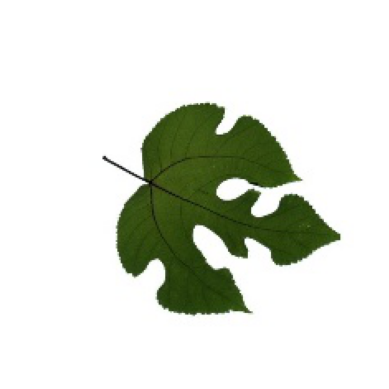

In [23]:
plt.imshow(image.permute(1,2,0))
plt.axis('off')
print(f'label of the image: {label}')

In [24]:
model = timm.create_model('resnet34', num_classes = 176)

In [25]:
Xt= torch.randn(1,3,224,224)
model(Xt).shape

torch.Size([1, 176])

In [26]:
# Build a cross val with Resnet with train data
from sklearn.model_selection import KFold

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)
criterion = nn.CrossEntropyLoss()


k = 5
num_epochs = 20
batch_size = 128

splits = KFold(n_splits=k, shuffle=True, random_state=42)


In [27]:
# Train and Eval functions
def train_epoch(model, device, dataloader, loss_f, optimizer):
    train_loss, train_correct = 0.0, 0
    model.train()

    for image, label in dataloader:
        image, label = image.to(device), label.type(torch.LongTensor).to(device)
        optimizer.zero_grad()
        output = model(image)
        loss = loss_f(output, label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * image.size(0)
        score, prediction = torch.max(output.data, 1)
        train_correct += (prediction == label).sum().item()

    return train_loss, train_correct

def valid_epoch(model, device, dataloader, loss_f):
    val_loss, val_correct, = 0.0, 0
    model.eval()
    with torch.no_grad():
        for image, label in dataloader:
            image, label = image.to(device), label.type(torch.LongTensor).to(device)
            output = model(image)
            loss = loss_f(output, label)
            val_loss += loss.item() * image.size(0)
            score, prediction = torch.max(output.data, 1)
            val_correct += (prediction == label).sum().item()

    return val_loss, val_correct

In [29]:
# Model train and eval

history = {'train_loss': [], 'train_acc':[]}


train_sampler = SubsetRandomSampler(np.arange(len(LeafTrain)))
train_loader = DataLoader(LeafTrain, batch_size=batch_size, sampler=train_sampler)

model = model
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

for epoch in range(num_epochs):
    train_loss, train_correct=train_epoch(model,device,train_loader,criterion,optimizer)

    train_loss = train_loss / len(train_loader.sampler)
    train_acc = train_correct / len(train_loader.sampler) * 100

    print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Training Acc {:.2f} %".format(epoch + 1, num_epochs,train_loss,train_acc))
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)

Epoch:1/20 AVG Training Loss:2.927 AVG Training Acc 24.75 %
Epoch:2/20 AVG Training Loss:2.089 AVG Training Acc 41.29 %
Epoch:3/20 AVG Training Loss:1.592 AVG Training Acc 53.85 %
Epoch:4/20 AVG Training Loss:1.268 AVG Training Acc 62.25 %
Epoch:5/20 AVG Training Loss:1.040 AVG Training Acc 67.62 %
Epoch:6/20 AVG Training Loss:0.869 AVG Training Acc 72.99 %
Epoch:7/20 AVG Training Loss:0.723 AVG Training Acc 77.02 %
Epoch:8/20 AVG Training Loss:0.633 AVG Training Acc 79.88 %
Epoch:9/20 AVG Training Loss:0.497 AVG Training Acc 83.95 %
Epoch:10/20 AVG Training Loss:0.465 AVG Training Acc 85.07 %
Epoch:11/20 AVG Training Loss:0.389 AVG Training Acc 87.26 %
Epoch:12/20 AVG Training Loss:0.336 AVG Training Acc 88.80 %
Epoch:13/20 AVG Training Loss:0.297 AVG Training Acc 89.95 %
Epoch:14/20 AVG Training Loss:0.278 AVG Training Acc 90.49 %
Epoch:15/20 AVG Training Loss:0.251 AVG Training Acc 91.66 %
Epoch:16/20 AVG Training Loss:0.211 AVG Training Acc 92.94 %
Epoch:17/20 AVG Training Loss:0.1

In [30]:
torch.save(model,'./res34.pt')

In [31]:
# Inference part 
# Generate a dict for the labels in the train

Leaf_mapping = LeafTrain.label_mapping

LeafTest = LeafImageDataset('./test.csv','',train=False, transform=transform)

In [32]:
submission = pd.read_csv('test.csv')
submission['label']=''

In [33]:

inf_sampler = SubsetRandomSampler(np.arange(len(LeafTest)))
test_loader = DataLoader(LeafTest, batch_size=batch_size, sampler=inf_sampler)

with torch.no_grad():
    for image, ind in test_loader:
        image= image.to(device)
        output = model(image)
        pred_class = torch.argmax(output,axis=1)

        for ind_s, pred_class_s in zip(ind, pred_class):
            #ind_np=ind_s.numpy()
            #pred_class_np = pred_class_s.cpu().numpy()
            submission.loc[int(ind_s),'label']=list(Leaf_mapping.keys())[list(Leaf_mapping.values()).index(int(pred_class_s.cpu()))]
            # print(f'Number {ind_s} sample got predicted label of {list(Leaf_mapping.keys())[list(Leaf_mapping.values()).index(pred_class_s)]}')


In [34]:
submission.head()

,image,label
0,images/18353.jpg,asimina_triloba
1,images/18354.jpg,tilia_europaea
2,images/18355.jpg,platanus_acerifolia
3,images/18356.jpg,pinus_cembra
4,images/18357.jpg,platanus_acerifolia


In [36]:
submission.to_csv('./submission_res34.csv', index=False)